In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 6.3 MB/s eta 0:00:00


# IMPORT LIBRARIES

In [2]:
# ===== Standard =====
import os
import time

# ===== PyTorch =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# ===== torchvision =====
from torchvision import datasets, transforms

# ===== snntorch =====
import snntorch as snn
from snntorch import spikegen, spikeplot as splt, utils

# ===== Other =====
import numpy as np
import matplotlib.pyplot as plt

# SET RANDOM SEED

In [3]:
np.random.seed(22520195)

# HELPER FUNCTION

In [4]:
def plot_potential_and_spikes(mem_potential, spikes, title, dt):
    """Plots membrane potential and spike times."""
    time_steps = np.arange(len(mem_potential)) * dt
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Membrane Potential (V)', color=color)
    ax1.plot(time_steps, mem_potential, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(min(mem_potential) - 0.01, max(mem_potential) + 0.01) # Adjust ylim for visibility

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    # ax2.set_ylabel('Spike', color=color)  # we already handled the x-label with ax1
    spike_times = np.where(spikes == 1)[0] * dt
    if len(spike_times) > 0 :
      ax2.eventplot(spike_times, linelengths=0.8, color=color, orientation='horizontal', lineoffset=0) # Draw spikes as vertical lines
    ax2.set_yticks([]) # Hide y-axis ticks for spikes
    # ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1) # Spike axis from 0 to 1

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_stdp_window(delta_t_values, delta_w_values, title="STDP Weight Change Window"):
    """Plots the classic STDP weight change curve."""
    plt.figure(figsize=(8, 5))
    plt.plot(delta_t_values[delta_t_values < 0], delta_w_values[delta_t_values < 0], 'o-', label='LTD (Post before Pre)')
    plt.plot(delta_t_values[delta_t_values > 0], delta_w_values[delta_t_values > 0], 'o-', label='LTP (Pre before Post)')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel('Δt = t_post - t_pre (ms)')
    plt.ylabel('Δw (Weight Change)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# DEVICE SETUP

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## **1. Encoding: Rate-Based to Spike Train (Poisson Encoding)**

In [6]:
def rate_encode_signal(signal, num_steps, gain=1.0):
    """
    Encodes a continuous signal into spike trains using rate coding (Bernoulli trials).
    """

    if signal.ndim == 0 or len(signal) == 1:  # Static signal
        # Nếu chỉ có 1 giá trị (hoặc scalar), nhân lên thành 1 tensor dài num_steps
        prob_tensor = torch.ones(num_steps) * signal.item() * gain

    elif len(signal) == num_steps:  # Time-varying signal
        # Nếu signal có đúng độ dài num_steps, ta dùng nó làm xác suất theo thời gian
        prob_tensor = signal * gain

    else:
        # Nếu độ dài signal < num_steps, ta lặp lại giá trị cuối để đủ độ dài
        print(f"Warning: Signal length ({len(signal)}) != num_steps ({num_steps}). Padding with last value.")
        padding_len = num_steps - len(signal)
        prob_tensor = torch.cat((signal, signal[-1].repeat(padding_len))) * gain

    # Đảm bảo xác suất nằm trong khoảng [0, 1]
    prob_tensor = torch.clamp(prob_tensor, 0, 1)

    # Mỗi bước thời gian thực hiện thử nghiệm Bernoulli để tạo spike (0 hoặc 1)
    spike_train = torch.bernoulli(prob_tensor)
    return spike_train

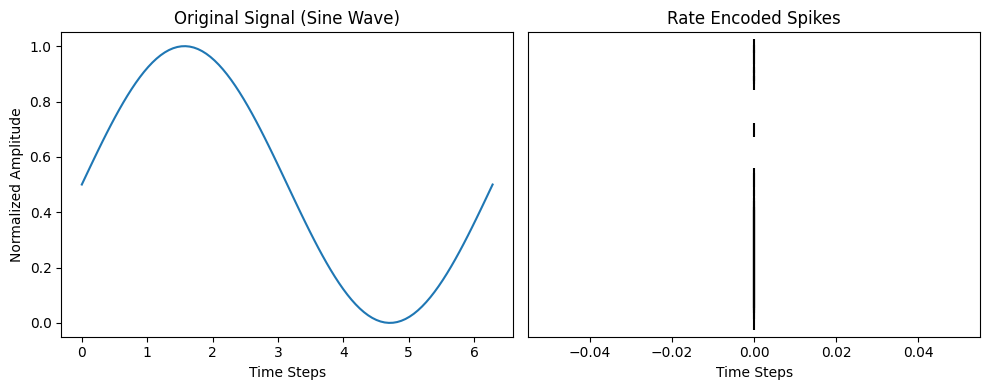

Generated 52 spikes out of 100 steps.


In [7]:
# Tạo tín hiệu hình sin và chuẩn hóa về khoảng [0, 1]
time = np.linspace(0, 2 * np.pi, 100)  # 100 điểm đều nhau từ 0 đến 2π
sine_signal = torch.tensor((np.sin(time) + 1) / 2, dtype=torch.float32)  # Chuẩn hóa sin(x) từ [-1, 1] về [0, 1]

num_steps_encoding = 100

# Mã hóa tín hiệu thành chuỗi spike bằng rate coding
rate_spikes = rate_encode_signal(sine_signal, num_steps_encoding)

# Vẽ biểu đồ
plt.figure(figsize=(10, 4))

# Trục 1: hiển thị tín hiệu hình sin gốc
plt.subplot(1, 2, 1)
plt.plot(time, sine_signal.numpy())
plt.title("Original Signal (Sine Wave)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Amplitude")

# Trục 2: hiển thị spike train dưới dạng raster plot
plt.subplot(1, 2, 2)
splt.raster(rate_spikes.unsqueeze(1).T, plt.gca(), s=100, c='black', marker='|')  # Thêm chiều giả để vẽ raster
plt.title("Rate Encoded Spikes")
plt.xlabel("Time Steps")
plt.yticks([])

plt.tight_layout()
plt.show()

# In số lượng spike được tạo ra
print(f"Generated {int(rate_spikes.sum())} spikes out of {num_steps_encoding} steps.")


## **2. Leaky Integrate-and-Fire (LIF) Neuron Model**

In [8]:
# Mô hình neuron Leaky Integrate-and-Fire (LIF) đơn giản
class LIFNeuron:
    """
    Mô phỏng mô hình neuron Leaky Integrate-and-Fire (LIF).
    Sử dụng phương pháp Euler để tích phân theo thời gian.
    """
    def __init__(self, tau_m=10e-3, v_rest=0.0, v_reset=-0.065, v_thresh=0.02, R_m=10e6):
        """
        Khởi tạo tham số neuron:
            - tau_m: hằng số thời gian màng
            - v_rest: điện thế nghỉ
            - v_reset: điện thế sau khi phát spike
            - v_thresh: ngưỡng phát spike
            - R_m: điện trở màng
        """
        self.tau_m = tau_m
        self.v_rest = v_rest
        self.v_reset = v_reset
        self.v_thresh = v_thresh
        self.R_m = R_m
        self.v_mem = self.v_rest  # Khởi tạo điện thế màng bằng điện thế nghỉ
        self.spikes = []  # Danh sách lưu lại các spike (0 hoặc 1)

    def step(self, I_inj, dt):
        """
        Mô phỏng 1 bước thời gian của neuron.

        Args:
            I_inj: dòng điện tiêm vào tại thời điểm hiện tại (A)
            dt: khoảng thời gian mô phỏng (s)

        Returns:
            v_mem: điện thế màng sau bước này
            spike_occurred: 1 nếu neuron phát spike, ngược lại 0
        """
        # Cập nhật điện thế màng theo phương pháp Euler
        dv = (-(self.v_mem - self.v_rest) + self.R_m * I_inj) / self.tau_m
        self.v_mem += dv * dt

        spike_occurred = 0
        # Kiểm tra nếu vượt ngưỡng thì phát spike và reset
        if self.v_mem >= self.v_thresh:
            self.v_mem = self.v_reset  # Reset điện thế màng
            spike_occurred = 1

        self.spikes.append(spike_occurred)
        return self.v_mem, spike_occurred

    def simulate(self, I_inj_over_time, dt):
        """
        Mô phỏng phản ứng của neuron với dòng điện thay đổi theo thời gian.

        Args:
            I_inj_over_time: danh sách dòng điện tại mỗi bước thời gian
            dt: bước thời gian

        Returns:
            v_mem_history: lịch sử điện thế màng
            spikes: lịch sử spike (0 hoặc 1)
        """
        self.v_mem = self.v_rest  # Reset trạng thái trước khi mô phỏng
        self.spikes = []
        v_mem_history = []

        for i in range(len(I_inj_over_time)):
            v, _ = self.step(I_inj_over_time[i], dt)  # Gọi step tại mỗi thời điểm
            v_mem_history.append(v)

        return np.array(v_mem_history), np.array(self.spikes)

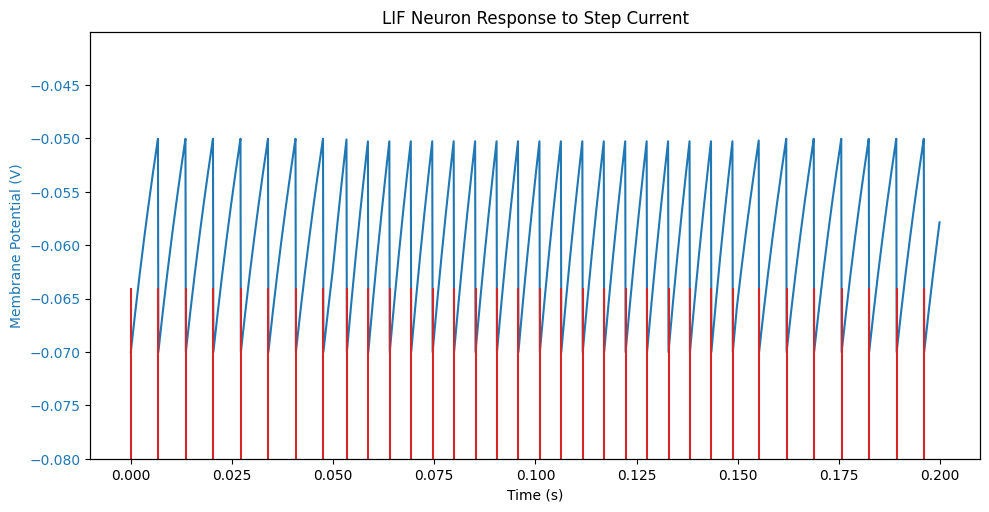

LIF Neuron generated 34 spikes.


In [9]:
# --- Ví dụ sử dụng mô hình LIF neuron ---
lif_neuron = LIFNeuron(
    tau_m=20e-3,       # Hằng số thời gian màng (20 ms)
    v_rest=0.0,        # Điện thế nghỉ
    v_reset=-0.070,    # Điện thế sau spike
    v_thresh=-0.050,   # Ngưỡng để phát spike
    R_m=10e6           # Điện trở màng
)

# Thông số mô phỏng
dt = 1e-4              # Bước thời gian: 0.1 ms
total_time = 0.2       # Tổng thời gian mô phỏng: 200 ms
num_steps_lif = int(total_time / dt)  # Tổng số bước thời gian

# Tạo dòng điện hình bậc thang: 0 → 1.6nA → 0
I_step = np.zeros(num_steps_lif)
I_step[int(0.05 / dt):int(0.15 / dt)] = 1.6e-9  # Dòng 1.6 nA từ 50ms đến 150ms

# Mô phỏng neuron với dòng điện I_step
v_history, spike_history = lif_neuron.simulate(I_step, dt)

# Vẽ đồ thị điện thế màng và các spike
plot_potential_and_spikes(
    v_history,
    spike_history,
    title="LIF Neuron Response to Step Current",
    dt=dt
)

# In ra tổng số spike neuron đã tạo ra
print(f"LIF Neuron generated {spike_history.sum()} spikes.")

## **3. STDP Rule (Spike-Timing-Dependent Plasticity)**

In [10]:
def update_stdp(weight, delta_t, A_plus=0.01, A_minus=0.01,
                tau_plus=20e-3, tau_minus=20e-3,
                w_max=1.0, w_min=0.0):
    """
    Cập nhật trọng số khớp thần kinh dựa trên sự chênh lệch thời gian giữa spike trước (pre) và sau (post).

    Args:
        weight (float): Trọng số hiện tại của synapse.
        delta_t (float): Độ trễ thời gian (t_post - t_pre), đơn vị: giây.
        A_plus (float): Hệ số học tăng cường (LTP) nếu pre xảy ra trước post.
        A_minus (float): Hệ số học suy yếu (LTD) nếu post xảy ra trước pre.
        tau_plus (float): Hằng số thời gian cho LTP (giảm dần).
        tau_minus (float): Hằng số thời gian cho LTD (giảm dần).
        w_max (float): Giới hạn trên cho trọng số.
        w_min (float): Giới hạn dưới cho trọng số.

    Returns:
        float: Trọng số synapse mới sau khi cập nhật.
    """
    delta_w = 0.0

    if delta_t > 0:
        # LTP: Pre xảy ra trước Post
        delta_w = A_plus * np.exp(-delta_t / tau_plus)
    elif delta_t < 0:
        # LTD: Post xảy ra trước Pre
        delta_w = -A_minus * np.exp(delta_t / tau_minus)

    # Cập nhật và giới hạn trọng số trong khoảng [w_min, w_max]
    new_weight = np.clip(weight + delta_w, w_min, w_max)
    return new_weight

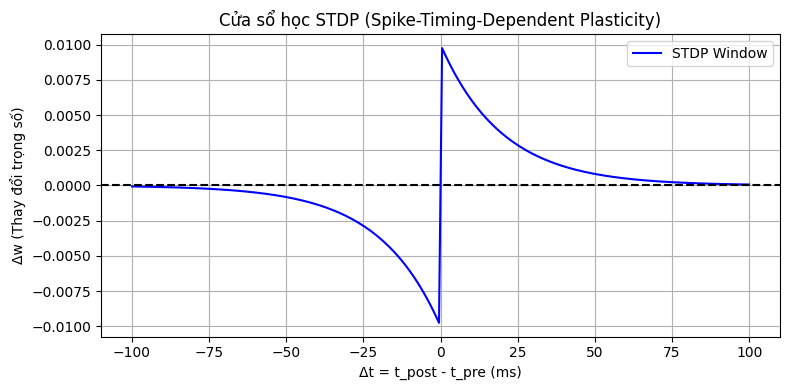

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def stdp_window(delta_t, A_plus=0.01, A_minus=0.01,
                tau_plus=20e-3, tau_minus=20e-3):
    """
    Tính toán sự thay đổi trọng số synapse dựa trên chênh lệch thời gian giữa pre và post.

    Args:
        delta_t (float): Δt = t_post - t_pre (giây)
        A_plus (float): Biên độ tăng trọng số (LTP)
        A_minus (float): Biên độ giảm trọng số (LTD)
        tau_plus (float): Hằng số thời gian cho LTP
        tau_minus (float): Hằng số thời gian cho LTD

    Returns:
        float: Giá trị thay đổi trọng số Δw
    """
    if delta_t > 0:
        return A_plus * np.exp(-delta_t / tau_plus)  # LTP
    elif delta_t < 0:
        return -A_minus * np.exp(delta_t / tau_minus)  # LTD
    else:
        return 0.0

# Tạo dữ liệu đầu vào: Δt từ -100ms đến +100ms
delta_t_range_ms = np.linspace(-100, 100, 200)
delta_t_range_s = delta_t_range_ms * 1e-3  # Đổi đơn vị sang giây
delta_w_list = [stdp_window(dt) for dt in delta_t_range_s]

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
plt.plot(delta_t_range_ms, delta_w_list, label="STDP Window", color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Δt = t_post - t_pre (ms)")
plt.ylabel("Δw (Thay đổi trọng số)")
plt.title("Cửa sổ học STDP (Spike-Timing-Dependent Plasticity)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
